### 1. Entrenamos RFC de reales y simulados básico

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader, read_table
import scipy
import seaborn as sns

# RandomForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Distribución del clasificador
import scipy.stats as stats

/tmp/ipykernel_29107/2707244459.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)

# Determinamos los parámetros
features = ['hillas_intensity', 'hillas_skewness', 'hillas_kurtosis', 'hillas_length', 'hillas_width', 'timing_slope']
protons_tel_events_f = protons_tel_events[features] 
protons_tel_events_f2 = protons_tel_events2[features] 

# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = ['intensity', 'skewness', 'kurtosis', 'length', 'width', 'time_gradient', 'event_type']
df_realC = tb[features]
# Convertimos a dataframe y eliminamos los NaN values
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)
# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 0)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos reales
df_real = df_realC

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real = df_real.head(df_simu.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)
y = df_simureal["label"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

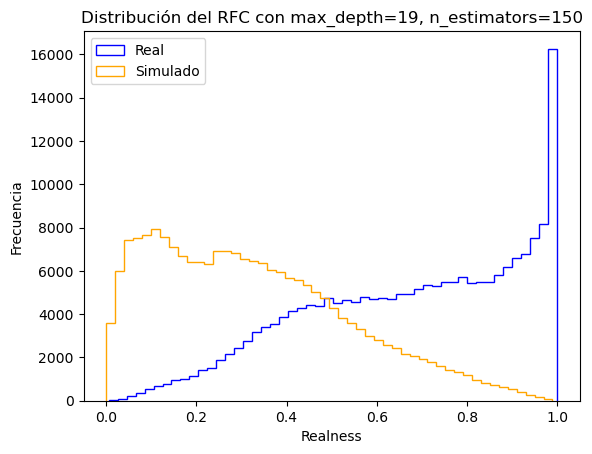

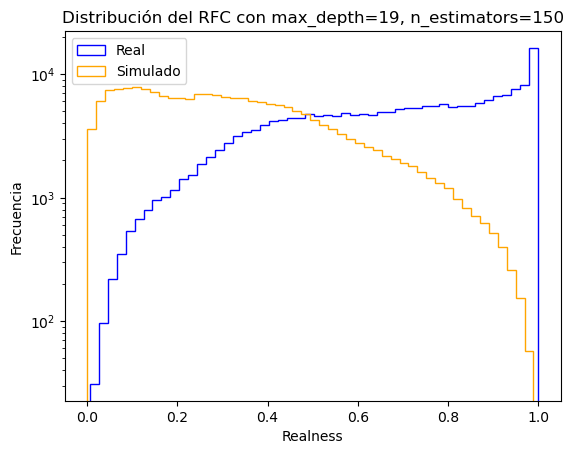

In [4]:
y_pred = (rfrs.predict_proba(X_test))
realness = y_pred[:,0]                                                                              # Gammaness predicha
label = y_test                                                                                       # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

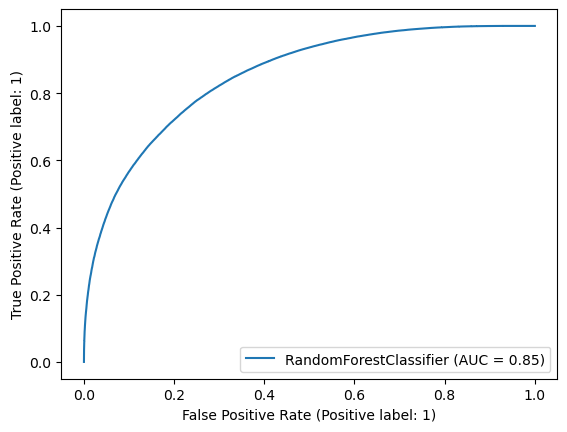

In [5]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs, X_test, y_test, ax=ax)
plt.show()

### 2. Filtrado a intensidades mayores de 200

In [6]:
# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

# Convertimos a dataframe y eliminamos los NaN values
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

df_realC = df_realC[(df_realC['hillas_intensity']>200)]
# Dataframe de datos reales
df_real = df_realC
# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real = df_real.head(df_simu.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)
y = df_simureal["label"]

#### 2.1 Predecir con el RFC anterior

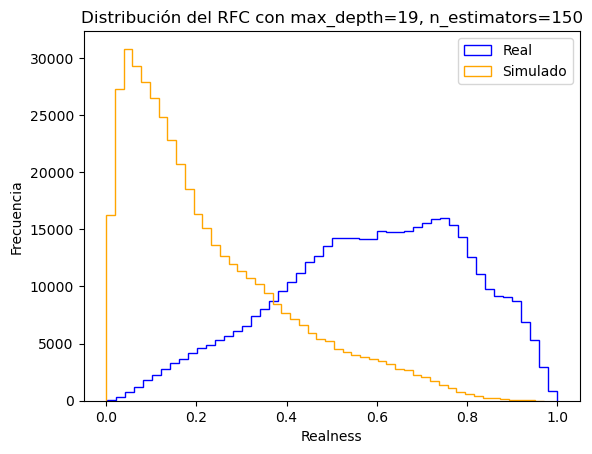

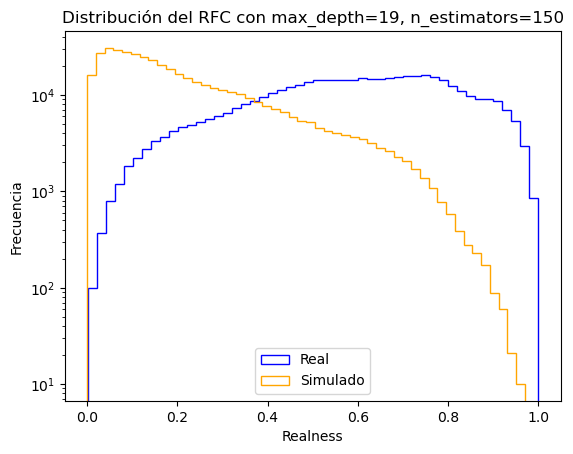

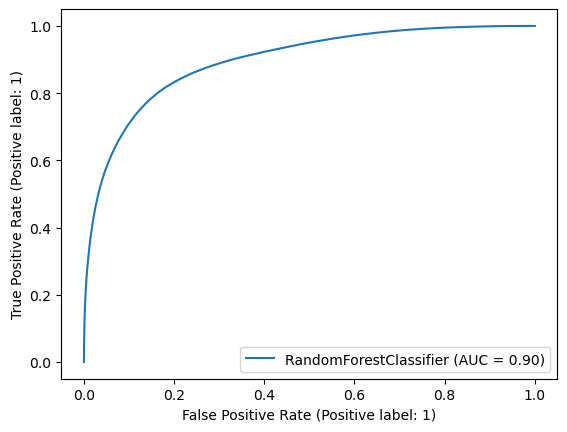

In [7]:
y_pred = (rfrs.predict_proba(X))
realness = y_pred[:,0]                                                                              # Gammaness predicha
label = y                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs, X, y, ax=ax)
plt.show()

#### 2.2 Entrenar modelo con los datos nuevos

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs2 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs2.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

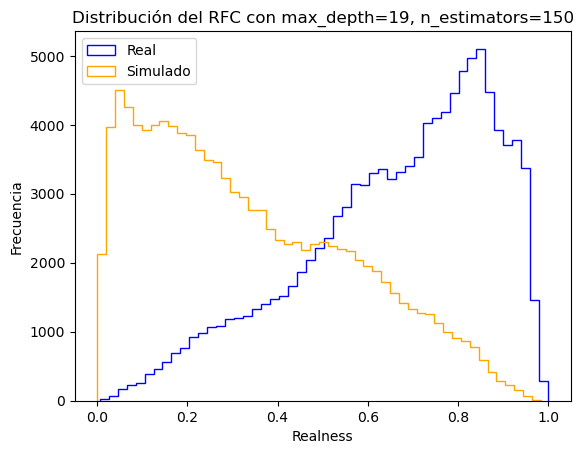

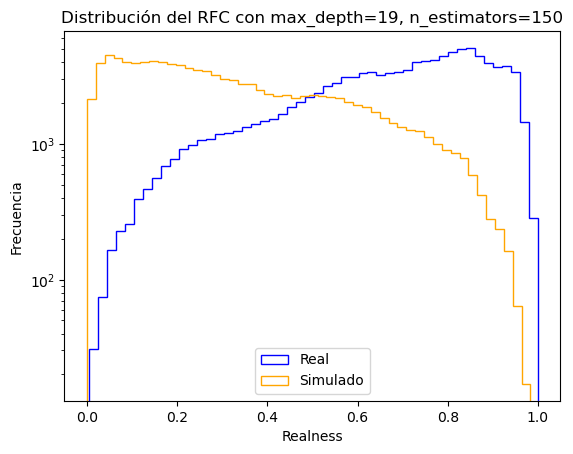

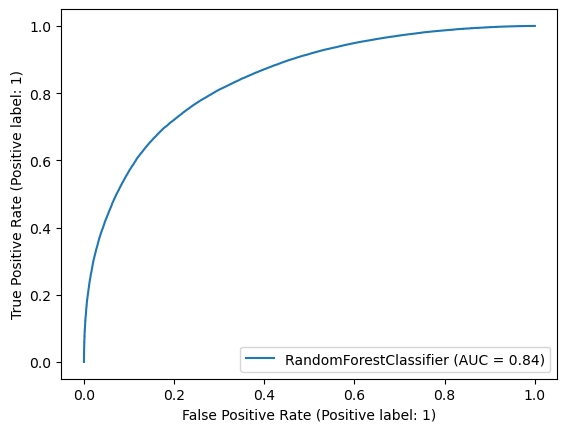

In [9]:
y_pred = (rfrs2.predict_proba(X_test))
realness = y_pred[:,0]                                                                              # Gammaness predicha
label = y_test                                                                                      # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs2, X_test, y_test, ax=ax)
plt.show()

### 3. Ajustar energía

In [10]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)

# Determinamos los parámetros
features = ['hillas_intensity', 'hillas_skewness', 'hillas_kurtosis', 'hillas_length', 'hillas_width', 'timing_slope', 'true_energy']
protons_tel_events_f = protons_tel_events[features] 
protons_tel_events_f2 = protons_tel_events2[features] 

# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

# ------- PROCESO DE AJUSTE DE LA ENERGÍA --------------------------------#
# PASO 1
# Añadimos una columna con los valores de la energía normalizados ya que solo podemos trabajar con datos mayores que 1
Emin = np.min(df_simu['true_energy'])
df_simu.loc[:, "true_energy_norm"] = df_simu['true_energy'].values/Emin
true_energy_20 = df_simu["true_energy_norm"]
# Mostramos el nuevo dataframe para comprobar los ajustes
print(df_simu)

# PASO 2
P = []
true_energy_20 = true_energy_20.values
for i in range(len(true_energy_20)):
    P.append(true_energy_20[i]**(-2.7) / true_energy_20[i]**(-2.0))

# PASO 3
def sobrevive(proba, energy):
    # Crear un nuevo array para almacenar los números sobrevivientes
    sobrevivientes = []
    # Iterar sobre los números y las probabilidades
    for i, probabilidad in enumerate(proba):
        # Generar un número aleatorio entre 0 y 1
        aleatorio = np.random.rand()
        # Si el número aleatorio es menor o igual a la probabilidad, el número sobrevive
        if aleatorio <= proba[i]:
            sobrevivientes.append(energy[i])
        else:
            sobrevivientes.append(0)
    return sobrevivientes

true_energy_27 = sobrevive(P, true_energy_20)

# PASO 4
# Filtramos el dataframe de simulados para los valores de true_energy_2.7 distintos a 0
df_simu.loc[:, "true_energy_filter"] = true_energy_27
df_simu = df_simu[df_simu['true_energy_filter'] != 0]
# Sacamos el dataframe de datos simulados finales
df_simu = df_simu.drop("true_energy", axis=1)
df_simu = df_simu.drop("true_energy_filter", axis=1)
df_simu = df_simu.drop("true_energy_norm", axis=1)
df_simu = df_simu.dropna()
# ------------------------------------------------------------------------------#

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = ['intensity', 'skewness', 'kurtosis', 'length', 'width', 'time_gradient', 'event_type']
df_realC = tb[features]
# Convertimos a dataframe y eliminamos los NaN values
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)
# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 0)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos reales
df_real = df_realC

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real = df_real.head(df_simu.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)
y = df_simureal["label"]

       hillas_intensity  hillas_skewness  hillas_kurtosis  hillas_length  \
3            577.332421         0.188235         1.695745       0.308969   
5            552.692280        -0.348821         2.403907       0.184209   
12           380.201642        -0.030697         1.641901       0.276596   
13           433.460289        -0.703524         2.374887       0.138545   
17           386.226773        -0.037960         2.168370       0.119900   
...                 ...              ...              ...            ...   
51415        273.299998         0.731815         2.918332       0.096856   
51417        914.260375        -1.029094         3.479541       0.543672   
51418        811.377876        -0.342327         2.062407       0.450407   
51419        558.215005        -0.396085         1.971028       0.529878   
51428        206.739210         0.155600         2.444209       0.109396   

       hillas_width  timing_slope  true_energy  true_energy_norm  
3          0.167774 

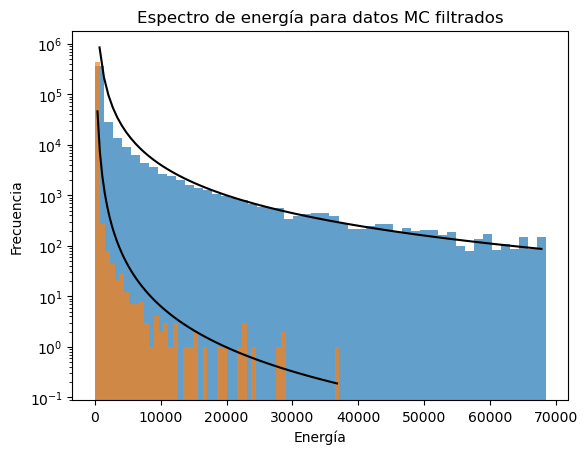

In [11]:
# Mostramos los dos espectros para comprobar que los efectos de filtrados son efectivos
# Ajuste exponencial
hist, bin_edges = np.histogram(true_energy_27, bins=50, density=True)
hist2, bin_edges2 = np.histogram(true_energy_20, bins=50, density=True)
x_data = (bin_edges[1:] + bin_edges[:-1]) / 2
x_data2 = (bin_edges2[1:] + bin_edges2[:-1]) / 2
x_fit = np.linspace(min(x_data), max(x_data), 100)
x_fit2 = np.linspace(min(x_data2), max(x_data2), 100)
y_fit = 400000000000*x_fit**(-2.7)
y_fit2 = 400000000000*x_fit2**(-2.0)
plt.hist(true_energy_20, 50, alpha = 0.7)
plt.hist(true_energy_27, 50, alpha = 0.7)
plt.plot(x_fit, y_fit, 'k')
plt.plot(x_fit2, y_fit2, 'k')
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.title('Espectro de energía para datos MC filtrados')
plt.show()

#### 3.1 Predecir con el RFC anterior

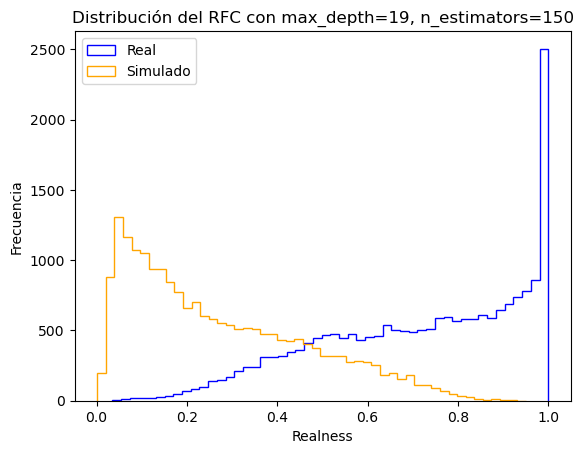

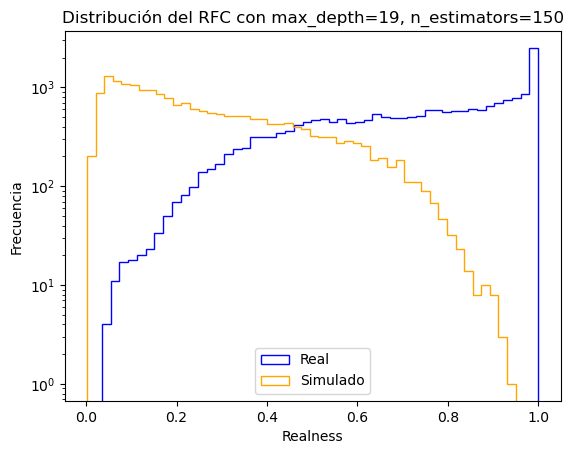

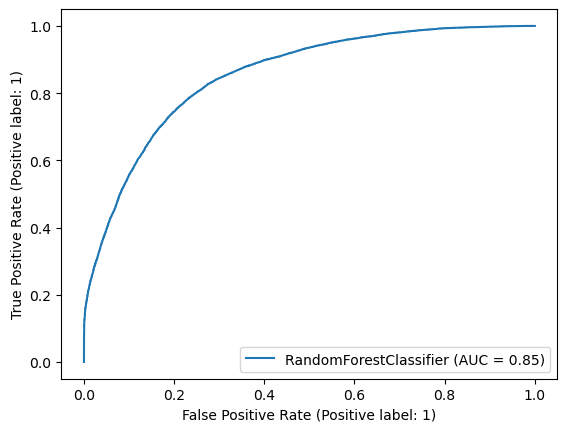

In [12]:
y_pred = (rfrs.predict_proba(X))
realness = y_pred[:,0]                                                                              # Gammaness predicha
label = y                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs2, X, y, ax=ax)
plt.show()

#### 3.2 Entrenar modelo con los datos nuevos

No hay suficientes datos después del filtro, esta parte se omite para este caso

### 4. Filtro de gammaness

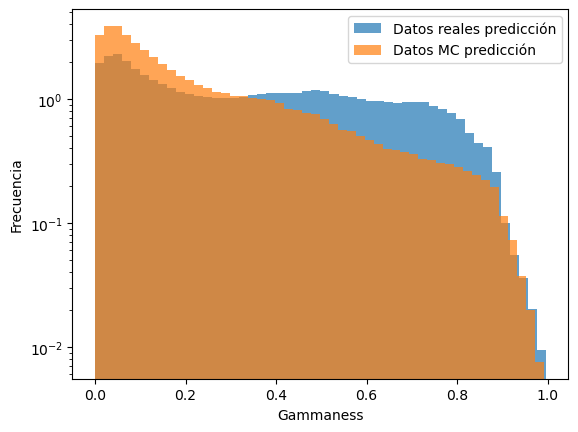

In [13]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protons)):
    label.append(1)                                                                   # Nombramos los protones como 1
for i2 in range(len(df_protons2)):
    label.append(1)
for j in range(len(df_gamma)):
    label.append(0)                                                                   # Nombramos los gamma como 0
for j2 in range(len(df_gamma2)):
    label.append(0)
    
df_protongamma.insert(6,"label", label, True)

Xc = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
yc = df_protongamma["label"]

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.25)
rfgammaness = RandomForestClassifier(max_depth=19, n_estimators=150)
rfgammaness.fit(X_train, y_train)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
df_realC = df_realC[(df_realC['intensity']>200)]

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]

# Eliminamos la columna de event_type del dataframe ya filtrado y ya tendríamos nuestros datos para el modelo
df_real = df_realC.drop("event_type", axis=1)

# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)

# Determinamos los parámetros
features = ['hillas_intensity', 'hillas_skewness', 'hillas_kurtosis', 'hillas_length', 'hillas_width', 'timing_slope']
protons_tel_events_f = protons_tel_events[features] 
protons_tel_events_f2 = protons_tel_events2[features] 

# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

y_pred = (rfgammaness.predict_proba(df_simu))
proba = y_pred[:,0]  
y_pred_real = (rfgammaness.predict_proba(df_real))
proba_real = y_pred_real[:,0] 

# Representamos ahora cómo es el espectro de las predicciones
plt.hist(proba_real, bins=50, density=True, alpha = 0.7, label = "Datos reales predicción")
plt.hist(proba, bins=50, density=True, alpha = 0.7, label = "Datos MC predicción")
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Gammaness')
plt.legend()
plt.show()

In [26]:
# Unimos los dataframes a su gammaness correspondiente
df_simu.loc[:, "gammaness"] = proba
df_real.loc[:, "gammaness"] = proba_real

# Eliminamos los eventos de alta gammaness
df_simu2 = df_simu[(df_simu['gammaness']<0.2)]
df_real2 = df_real[(df_real['gammaness']<0.2)]

df_simu2 = df_simu2.drop("gammaness", axis=1)
df_real2 = df_real2.drop("gammaness", axis=1)

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real2 = df_real2.head(df_simu.shape[0])
df_simu2 = df_simu2.head(df_real.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu2)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real2)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu2, df_real2], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)
y = df_simureal["label"]

#### 4.1 Predecir con el RFC anterior

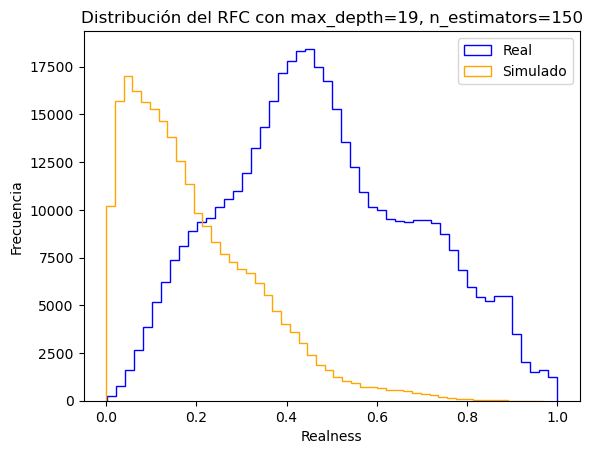

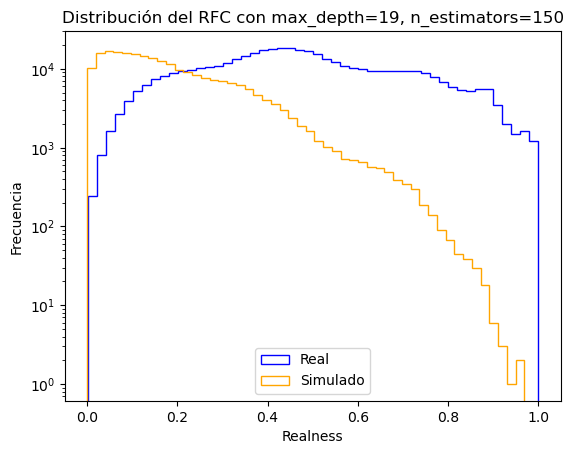

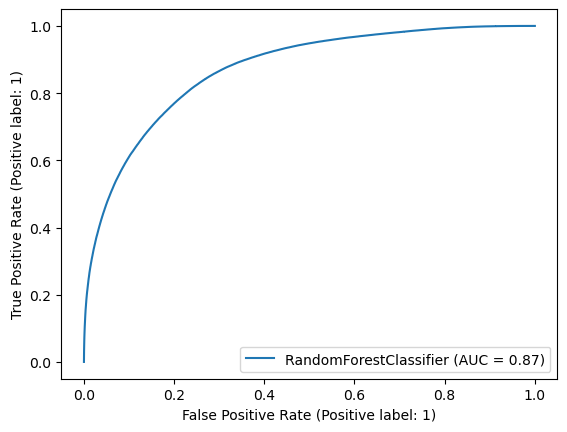

In [27]:
y_pred = (rfrs.predict_proba(X))
realness = y_pred[:,0]                                                                              # Gammaness predicha
label = y                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs, X, y, ax=ax)
plt.show()

#### 4.2 Entrenar modelo con los datos nuevos

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs2 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs2.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

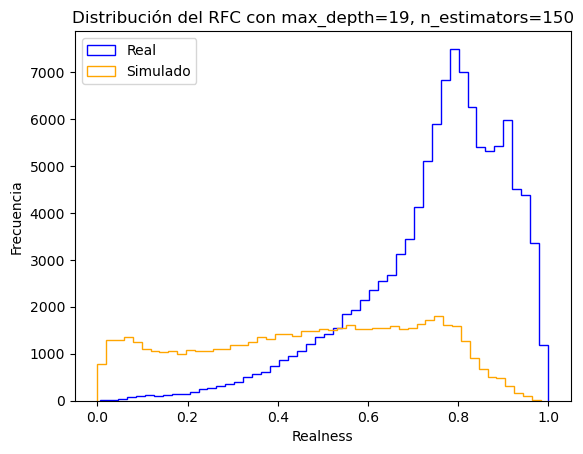

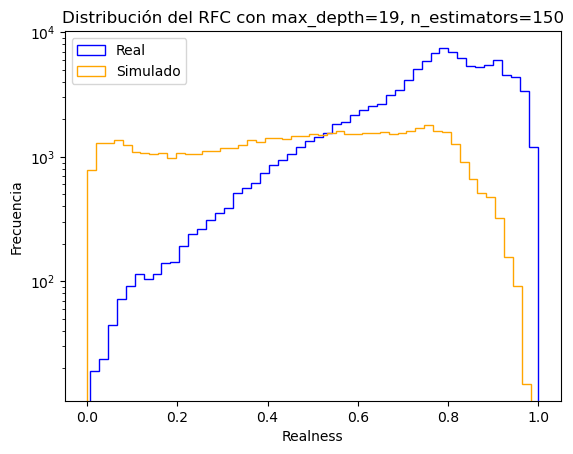

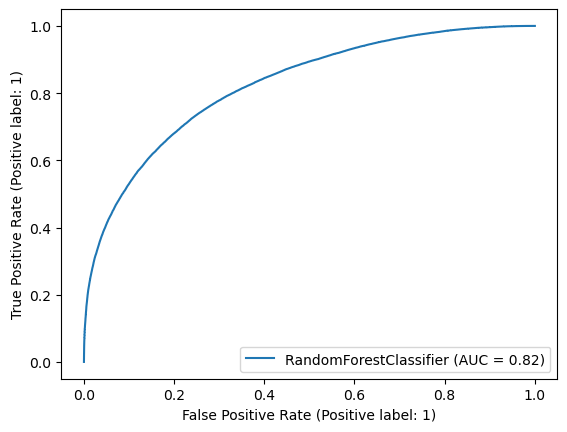

In [29]:
y_pred = (rfrs2.predict_proba(X_test))
realness = y_pred[:,0]                                                                              # Gammaness predicha
label = y_test                                                                                      # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs2, X_test, y_test, ax=ax)
plt.show()

### 5. Relación entre los parámetros para esta última distribución

In [30]:
# Preparamos la representación
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(ax, x, y):
    if np.all(x > 0):
        ax.set_xscale('log')
    if np.all(y > 0):
        ax.set_yscale('log')
    density = ax.scatter_density(x, y, cmap=white_viridis)

titles = ['Intensity', 'Skweness', 'Kurtosis', 'Length', 'Width', 'Time slope']

/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


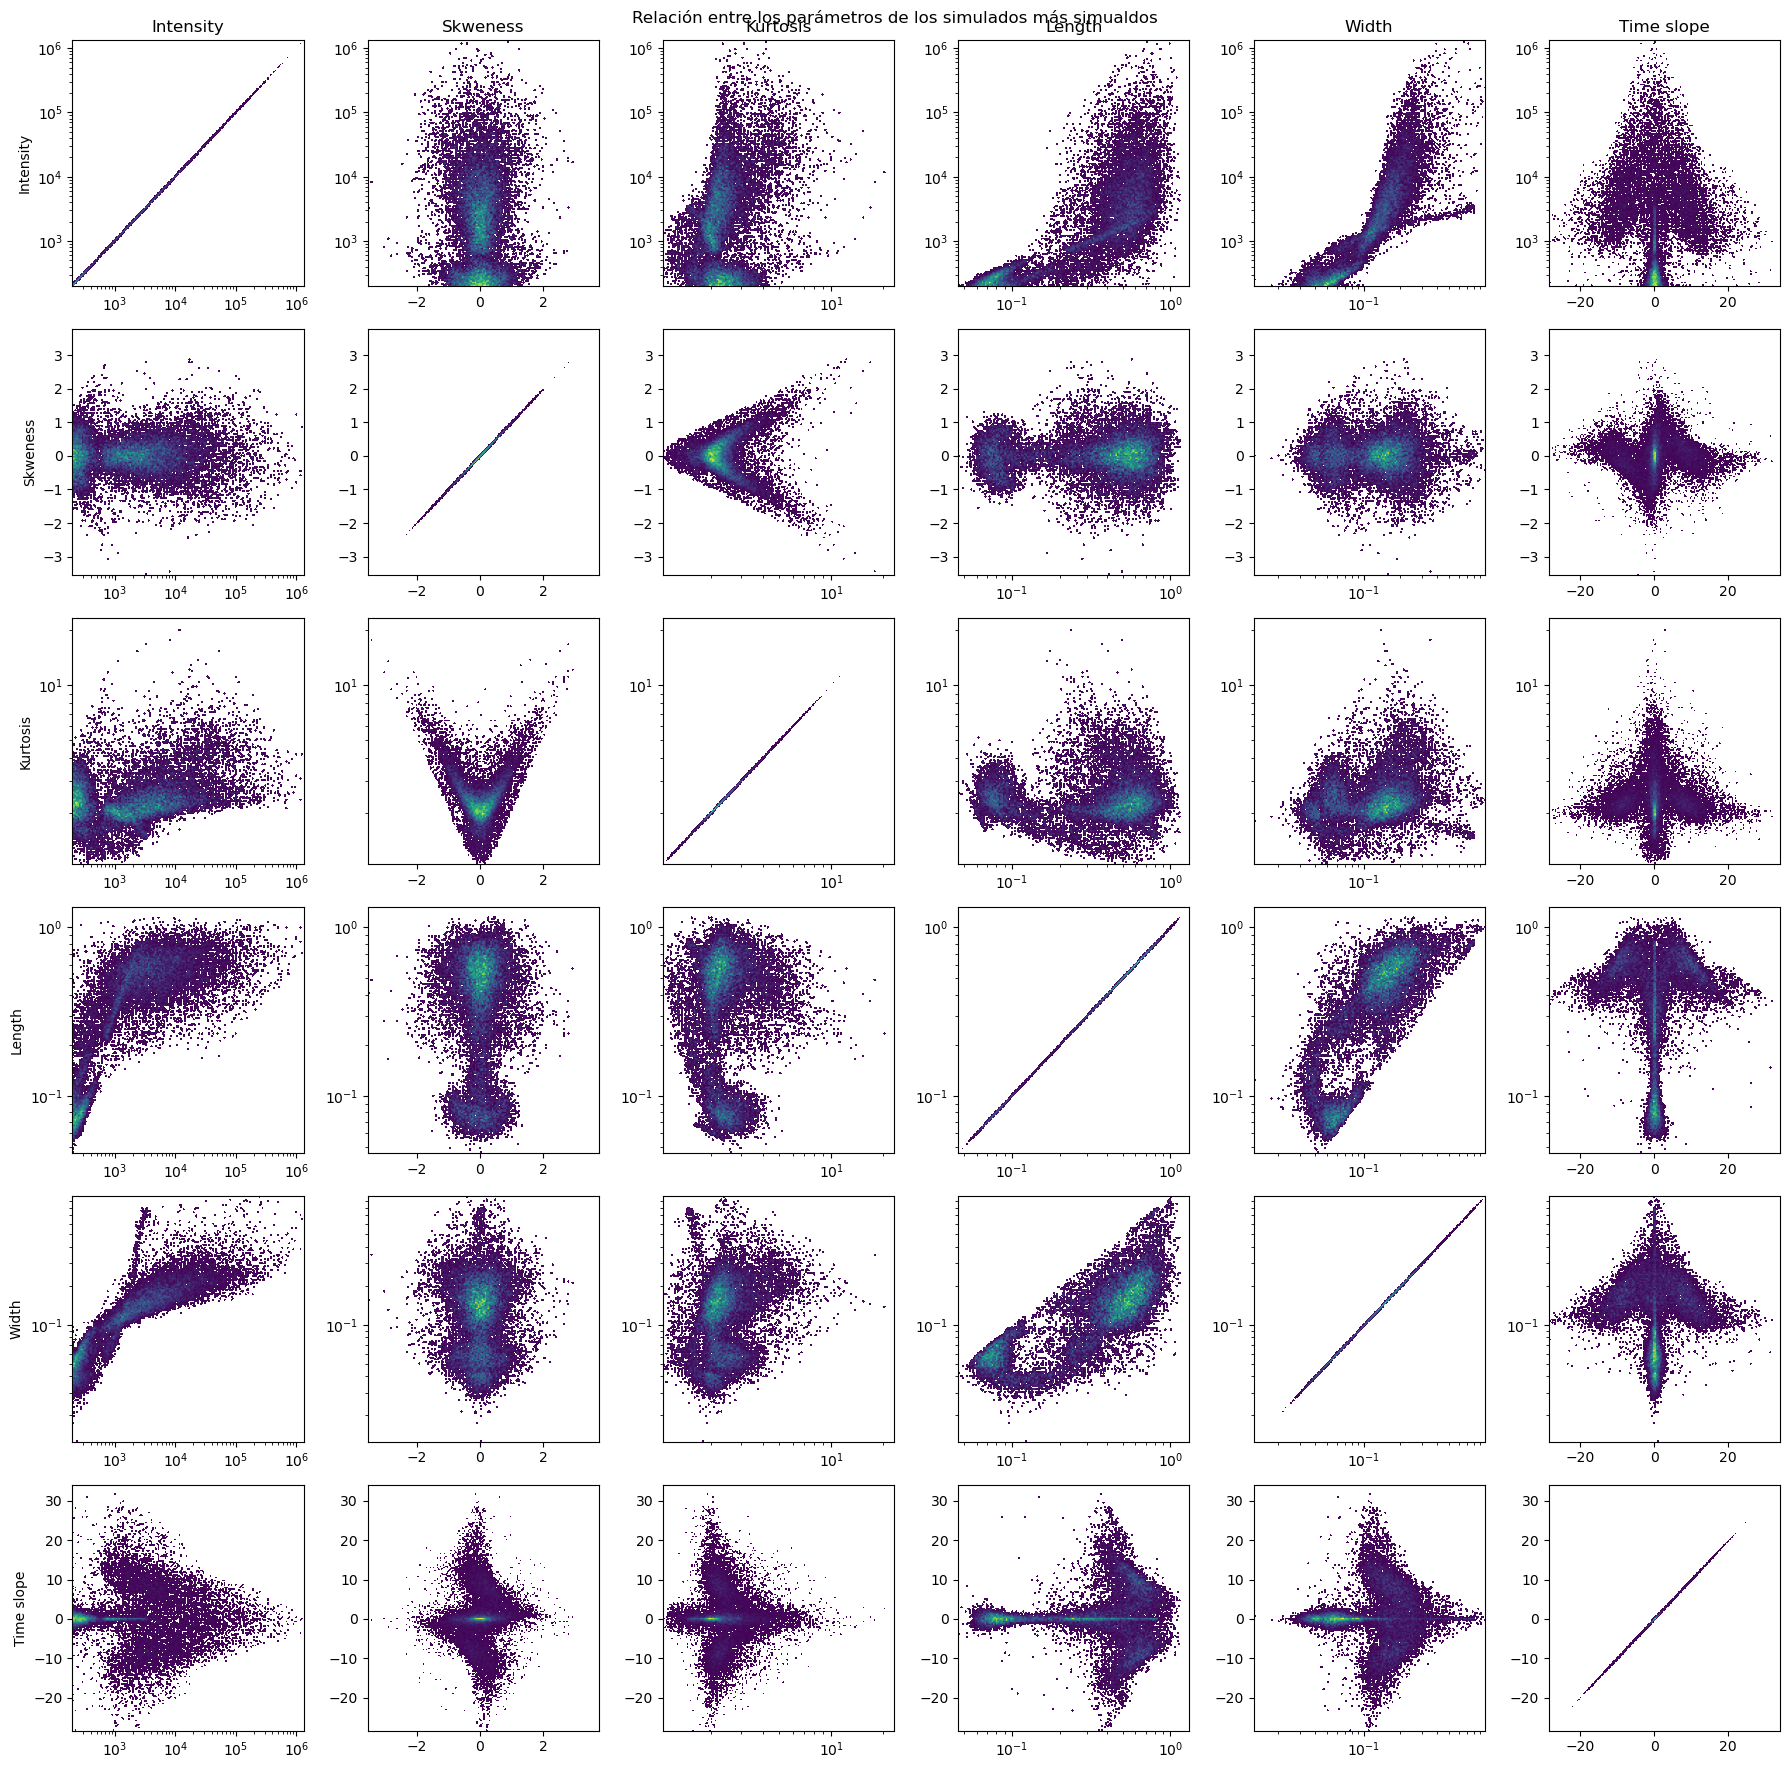

In [31]:
#y_pred = (rfrs.predict_proba(X_test))
realness = y_pred[:,0]

# Juntamos todos los datos
data = np.column_stack((X_test, y_test))
data = np.column_stack((data, realness))

# Filtramos los datos para que tengan las mismas dimensiones
data = data[data[:, 4] > 10**(-4)]

# Separamos los datos en reales y simulados
X_reales = data[data[:, 6] == 0]
X_simulados = data[data[:, 6] == 1]

# Separamos los reales y simulados en más reales y más simulados
X_simulados_mas = X_simulados[X_simulados[:,7] <= 0.3]
X_simulados_menos = X_simulados[X_simulados[:,7] >= 0.7]
X_reales_mas = X_reales[X_reales[:,7] >= 0.7]
X_reales_menos = X_reales[X_reales[:,7] <= 0.3]

# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        # Representar los datos
        using_mpl_scatter_density(ax, X_simulados_mas[:, j], X_simulados_mas[:, i])

plt.suptitle('Relación entre los parámetros de los simulados más simualdos')
plt.tight_layout()
plt.show()

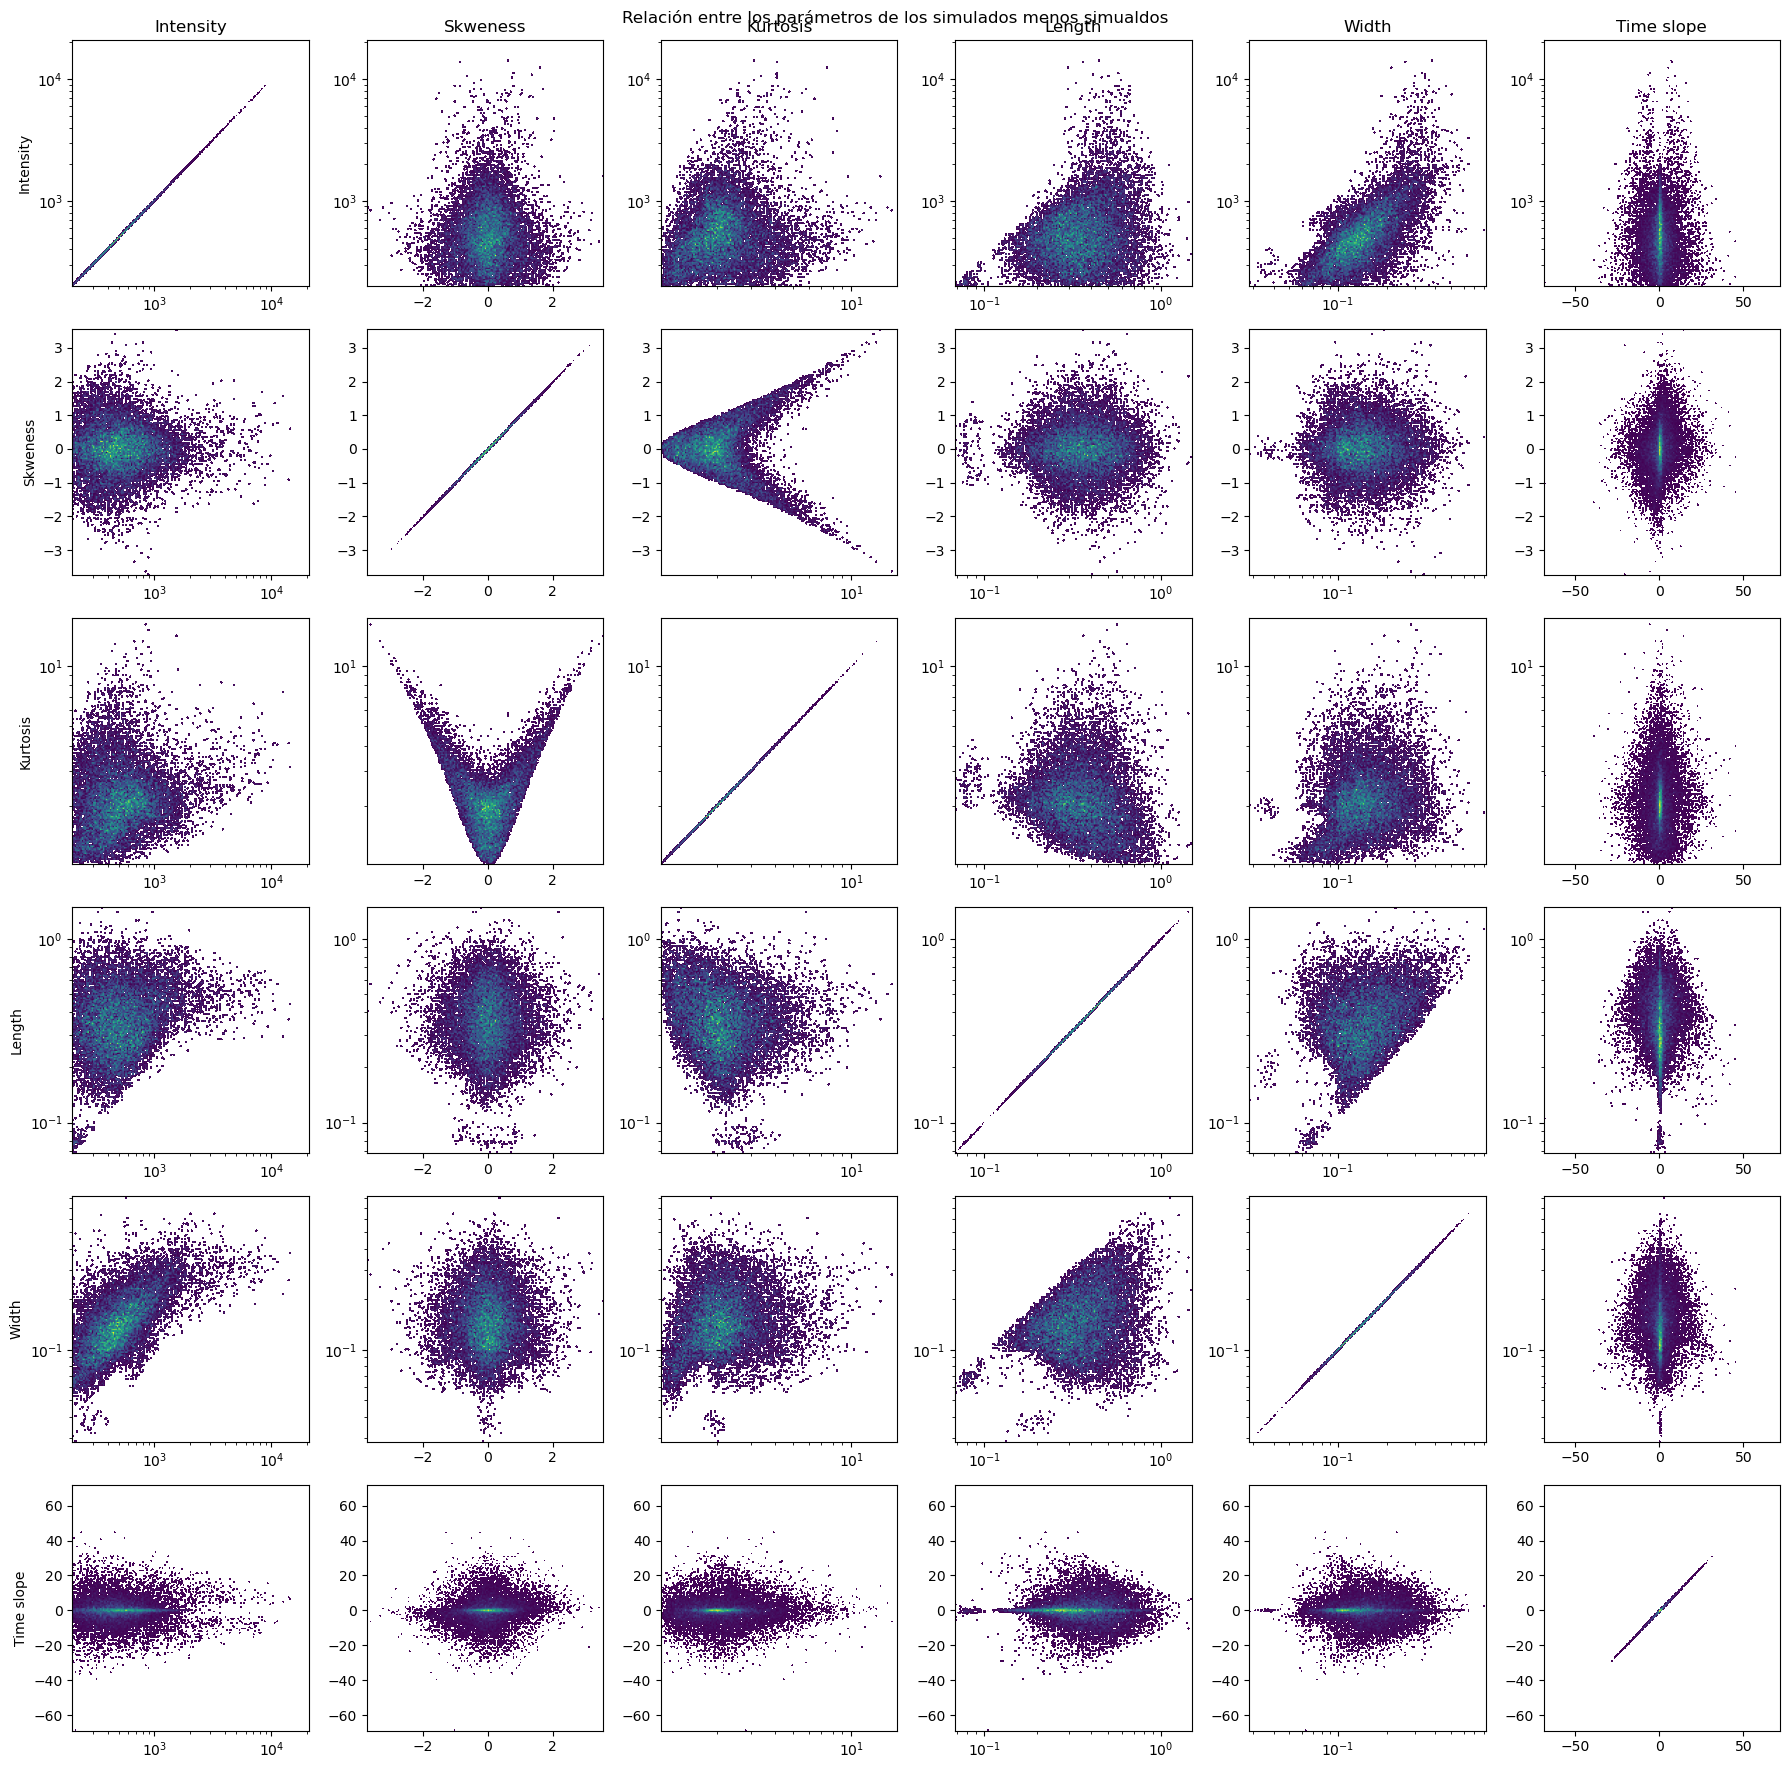

In [32]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        # Representar los datos
        using_mpl_scatter_density(ax, X_simulados_menos[:, j], X_simulados_menos[:, i])

plt.suptitle('Relación entre los parámetros de los simulados menos simualdos')
plt.tight_layout()
plt.show()

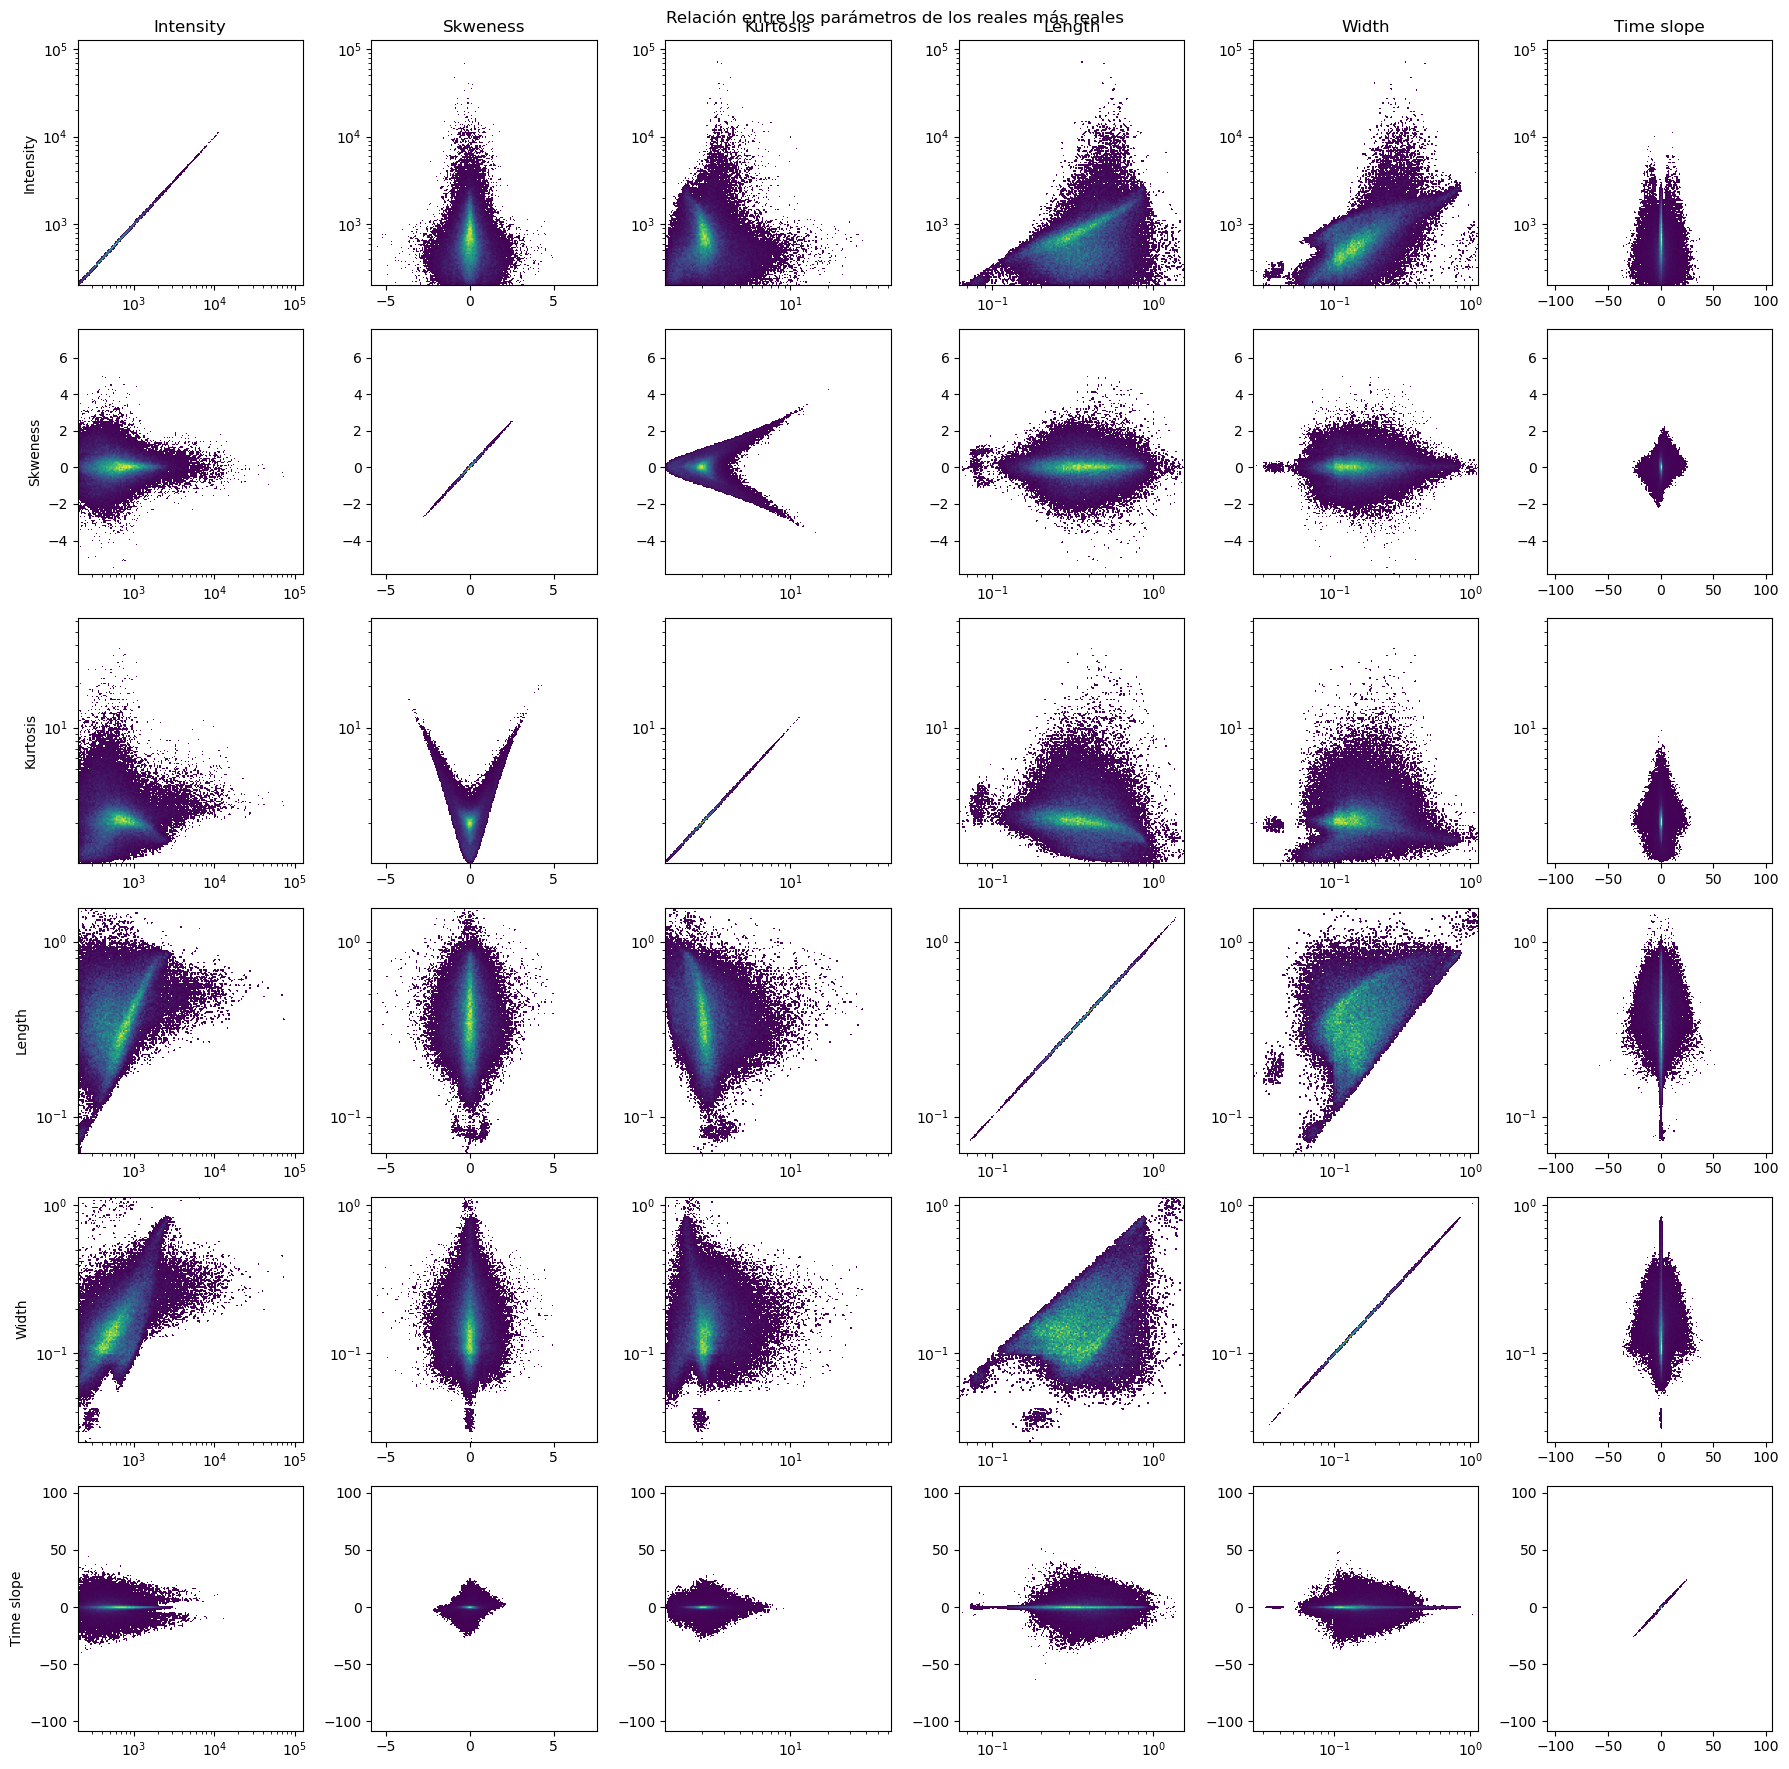

In [33]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        # Representar los datos
        using_mpl_scatter_density(ax, X_reales_mas[:, j], X_reales_mas[:, i])

plt.suptitle('Relación entre los parámetros de los reales más reales')
plt.tight_layout()
plt.show()

In [35]:
print(len(X_simulados_mas))
print(len(X_simulados_menos))
print(len(X_reales_mas))
print(len(X_reales_menos))

16918
13391
78509
2159


/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_29107/2947986349.py:25: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=X_simulados_mas[:-14418, j], y=X_simulados_mas[:-14418, i], cmap='Blues', thresh=0.02, ax=ax)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is depre

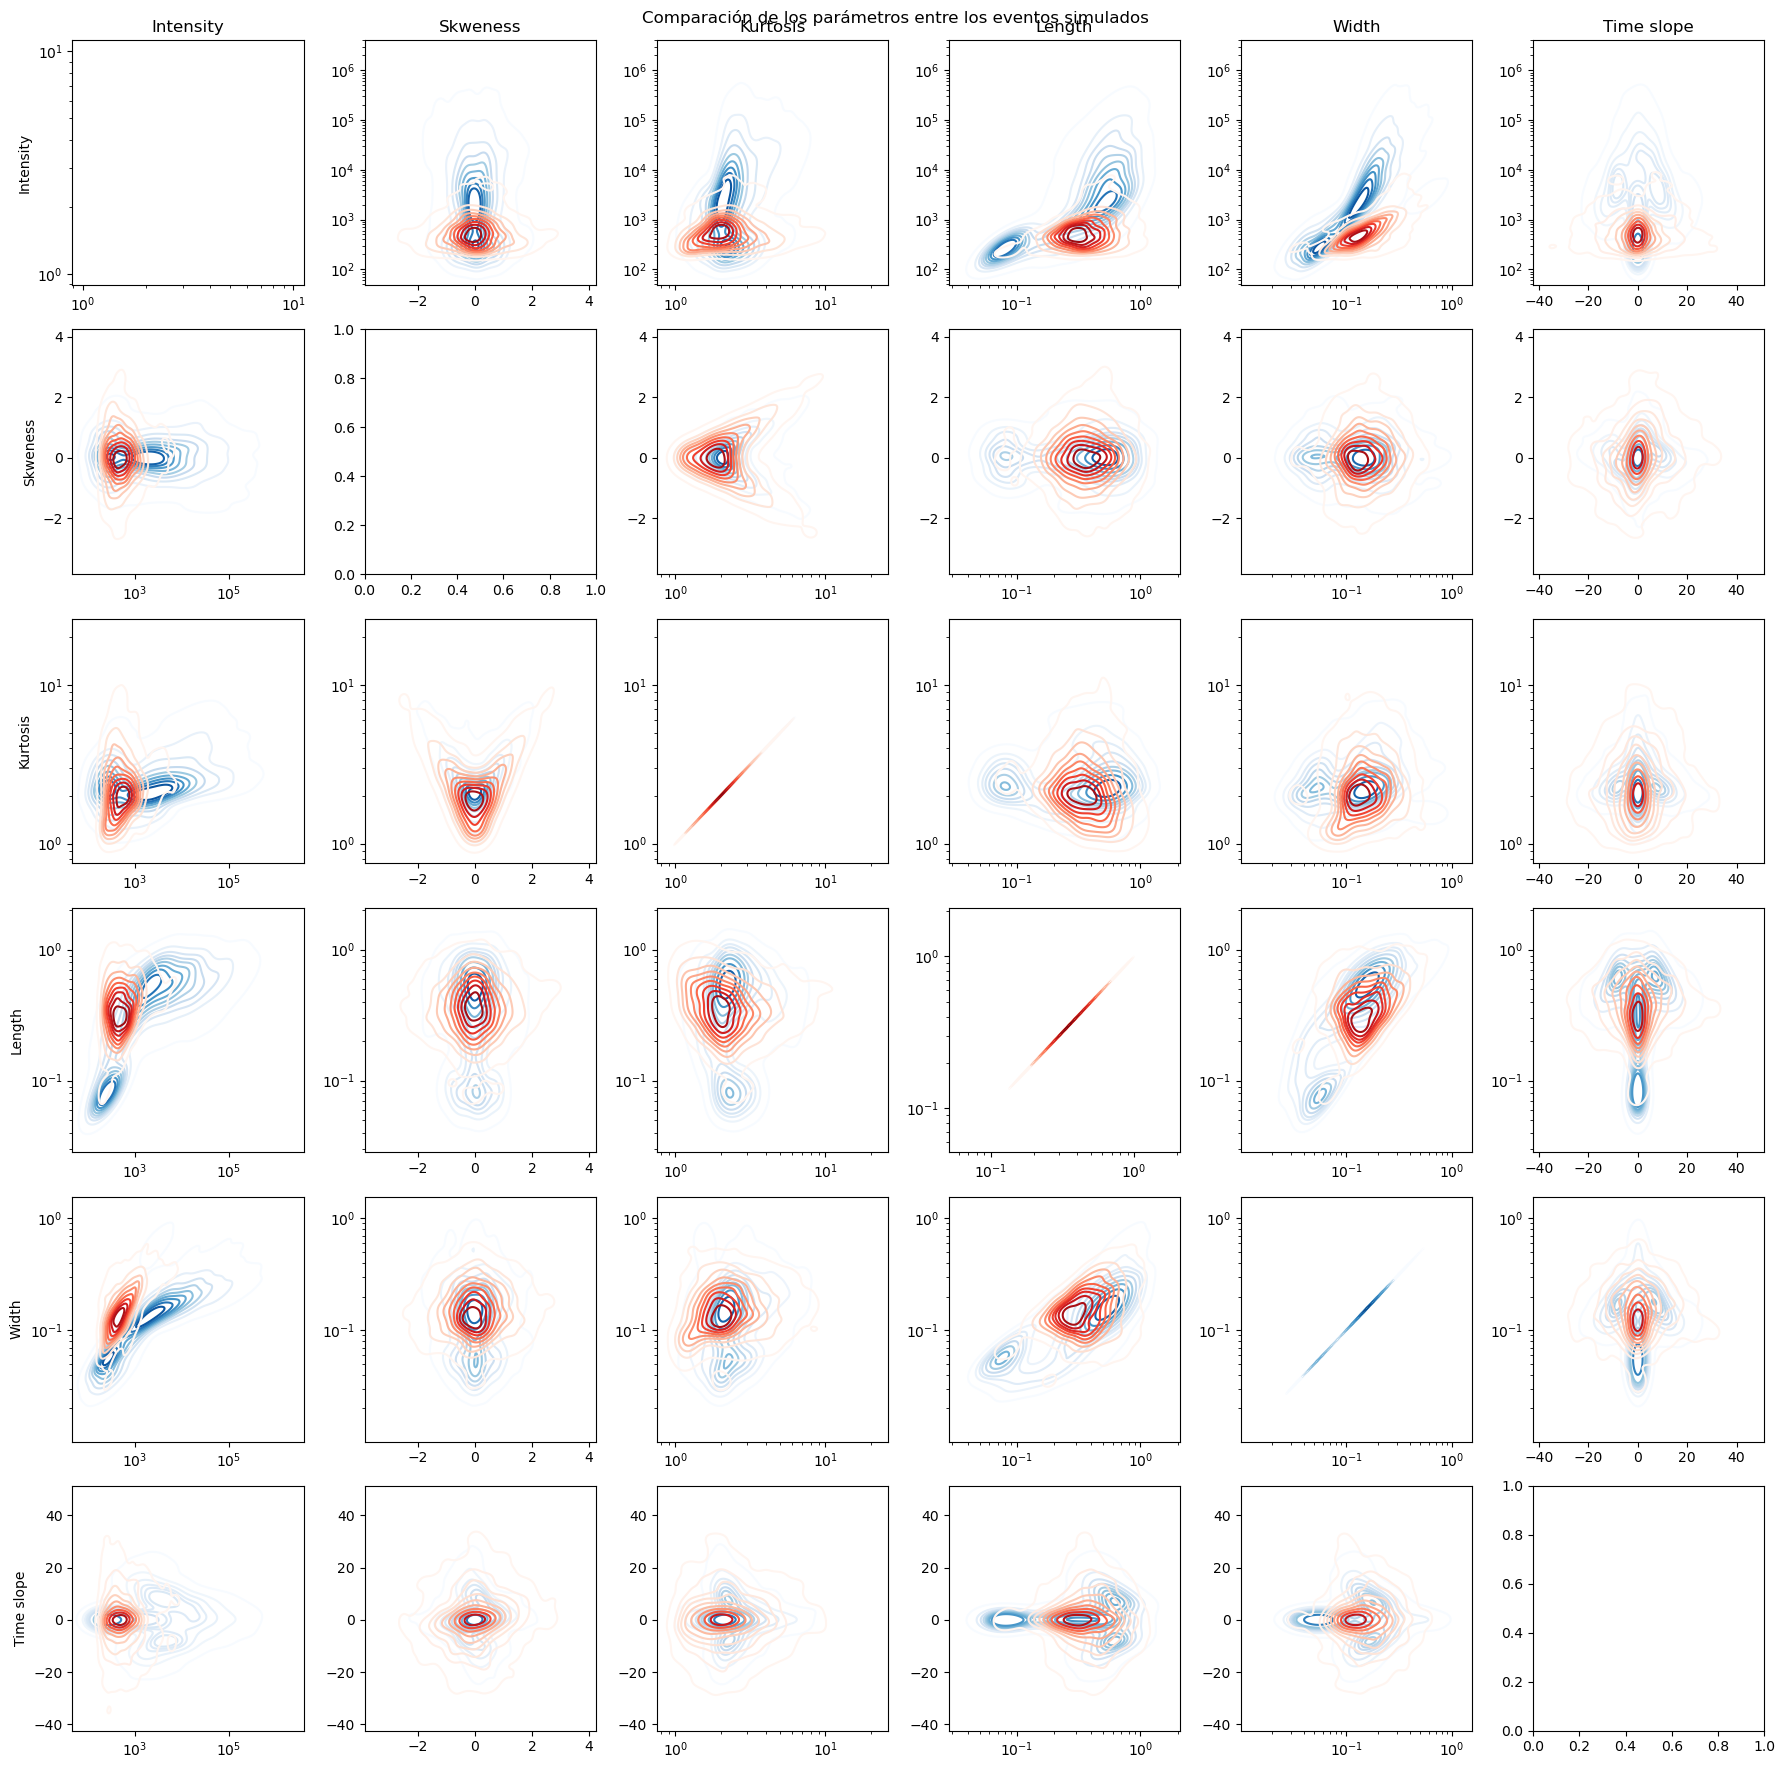

In [37]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        if np.all(X_simulados_mas[:-14418, j] > 0) and np.all(X_simulados_menos[:-10891, j] > 0):
            ax.set_xscale('log')
        if np.all(X_simulados_mas[:-14418, i] > 0) and np.all(X_simulados_menos[:-10891, i] > 0):
            ax.set_yscale('log')
        
        # Representar los datos
        sns.kdeplot(x=X_simulados_mas[:-14418, j], y=X_simulados_mas[:-14418, i], cmap='Blues', thresh=0.02, ax=ax)
        sns.kdeplot(x=X_simulados_menos[:-10891, j], y=X_simulados_menos[:-10891, i], cmap='Reds', thresh=0.02, ax=ax)
        
plt.suptitle('Comparación de los parámetros entre los eventos simulados')
plt.tight_layout()
plt.show()

fig.savefig('Comparación simulados5.png')

/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_29107/3447823449.py:25: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=X_reales_mas[:-76009, j], y=X_reales_mas[:-76009, i], cmap='Blues', thresh=0.02, ax=ax)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated 

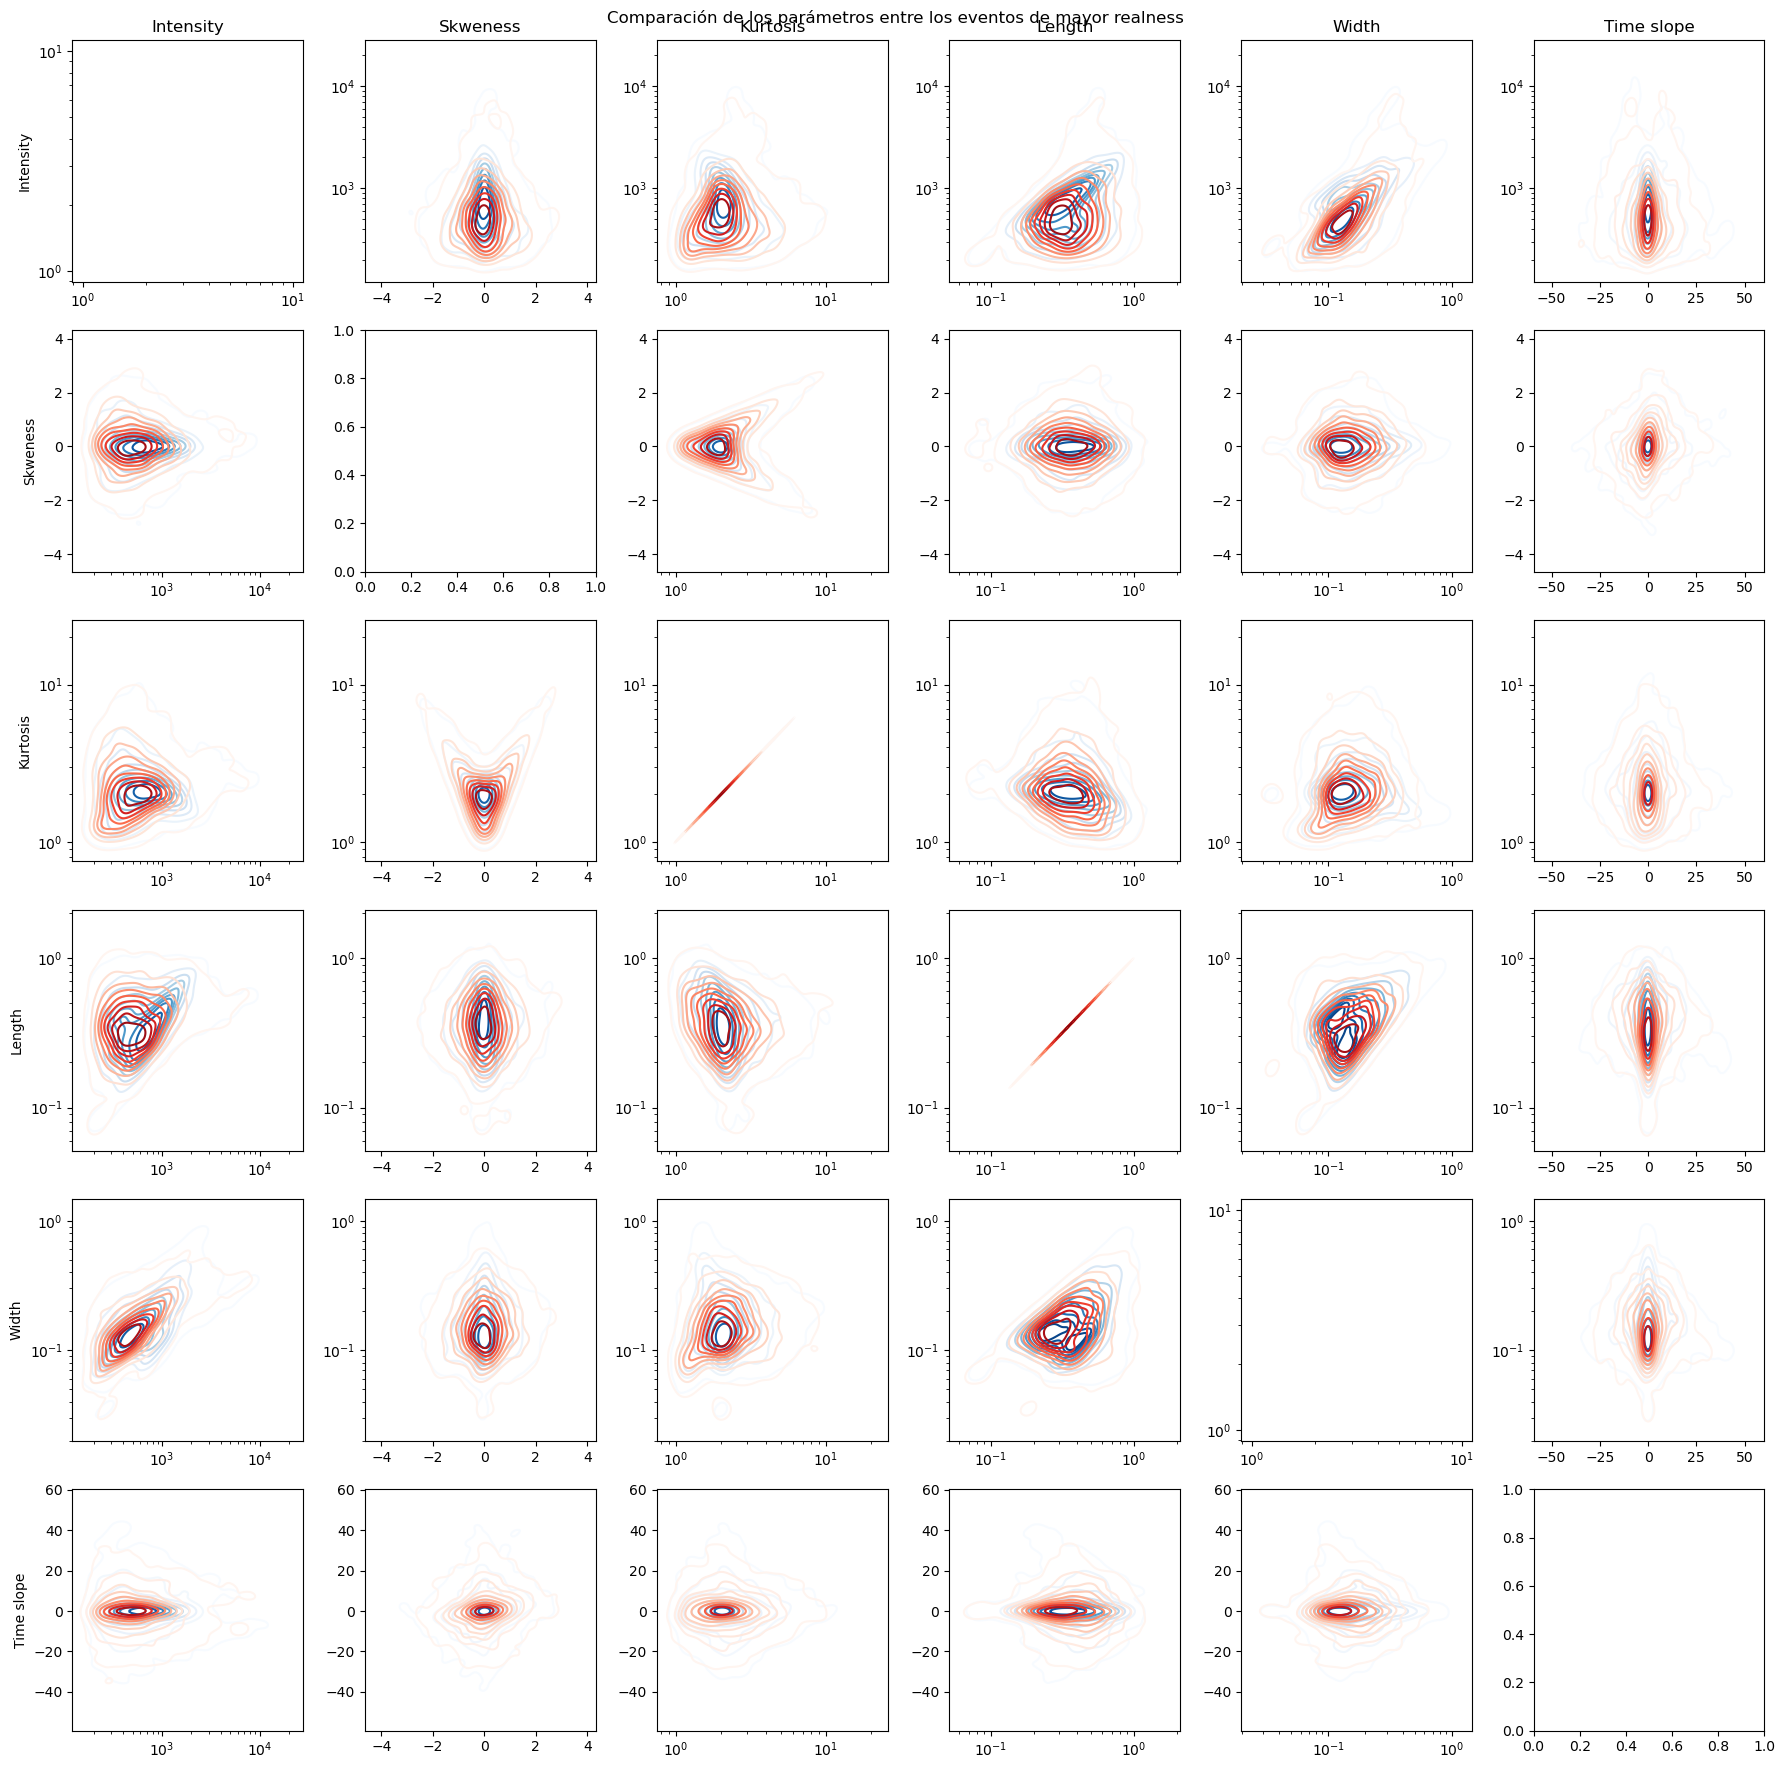

In [38]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        if np.all(X_reales_mas[:-76009, j] > 0) and np.all(X_simulados_menos[:-10891, j] > 0):
            ax.set_xscale('log')
        if np.all(X_reales_mas[:-76009, i] > 0) and np.all(X_simulados_menos[:-10891, i] > 0):
            ax.set_yscale('log')
        
        # Representar los datos
        sns.kdeplot(x=X_reales_mas[:-76009, j], y=X_reales_mas[:-76009, i], cmap='Blues', thresh=0.02, ax=ax)
        sns.kdeplot(x=X_simulados_menos[:-10891, j], y=X_simulados_menos[:-10891, i], cmap='Reds', thresh=0.02, ax=ax)
        
plt.suptitle('Comparación de los parámetros entre los eventos de mayor realness')
plt.tight_layout()
plt.show()

fig.savefig('Comparación reales5.png')

/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_29107/2319201992.py:25: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=X_simulados_mas[:-14418, j], y=X_simulados_mas[:-14418, i], cmap='Blues', thresh=0.02, ax=ax)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is depre

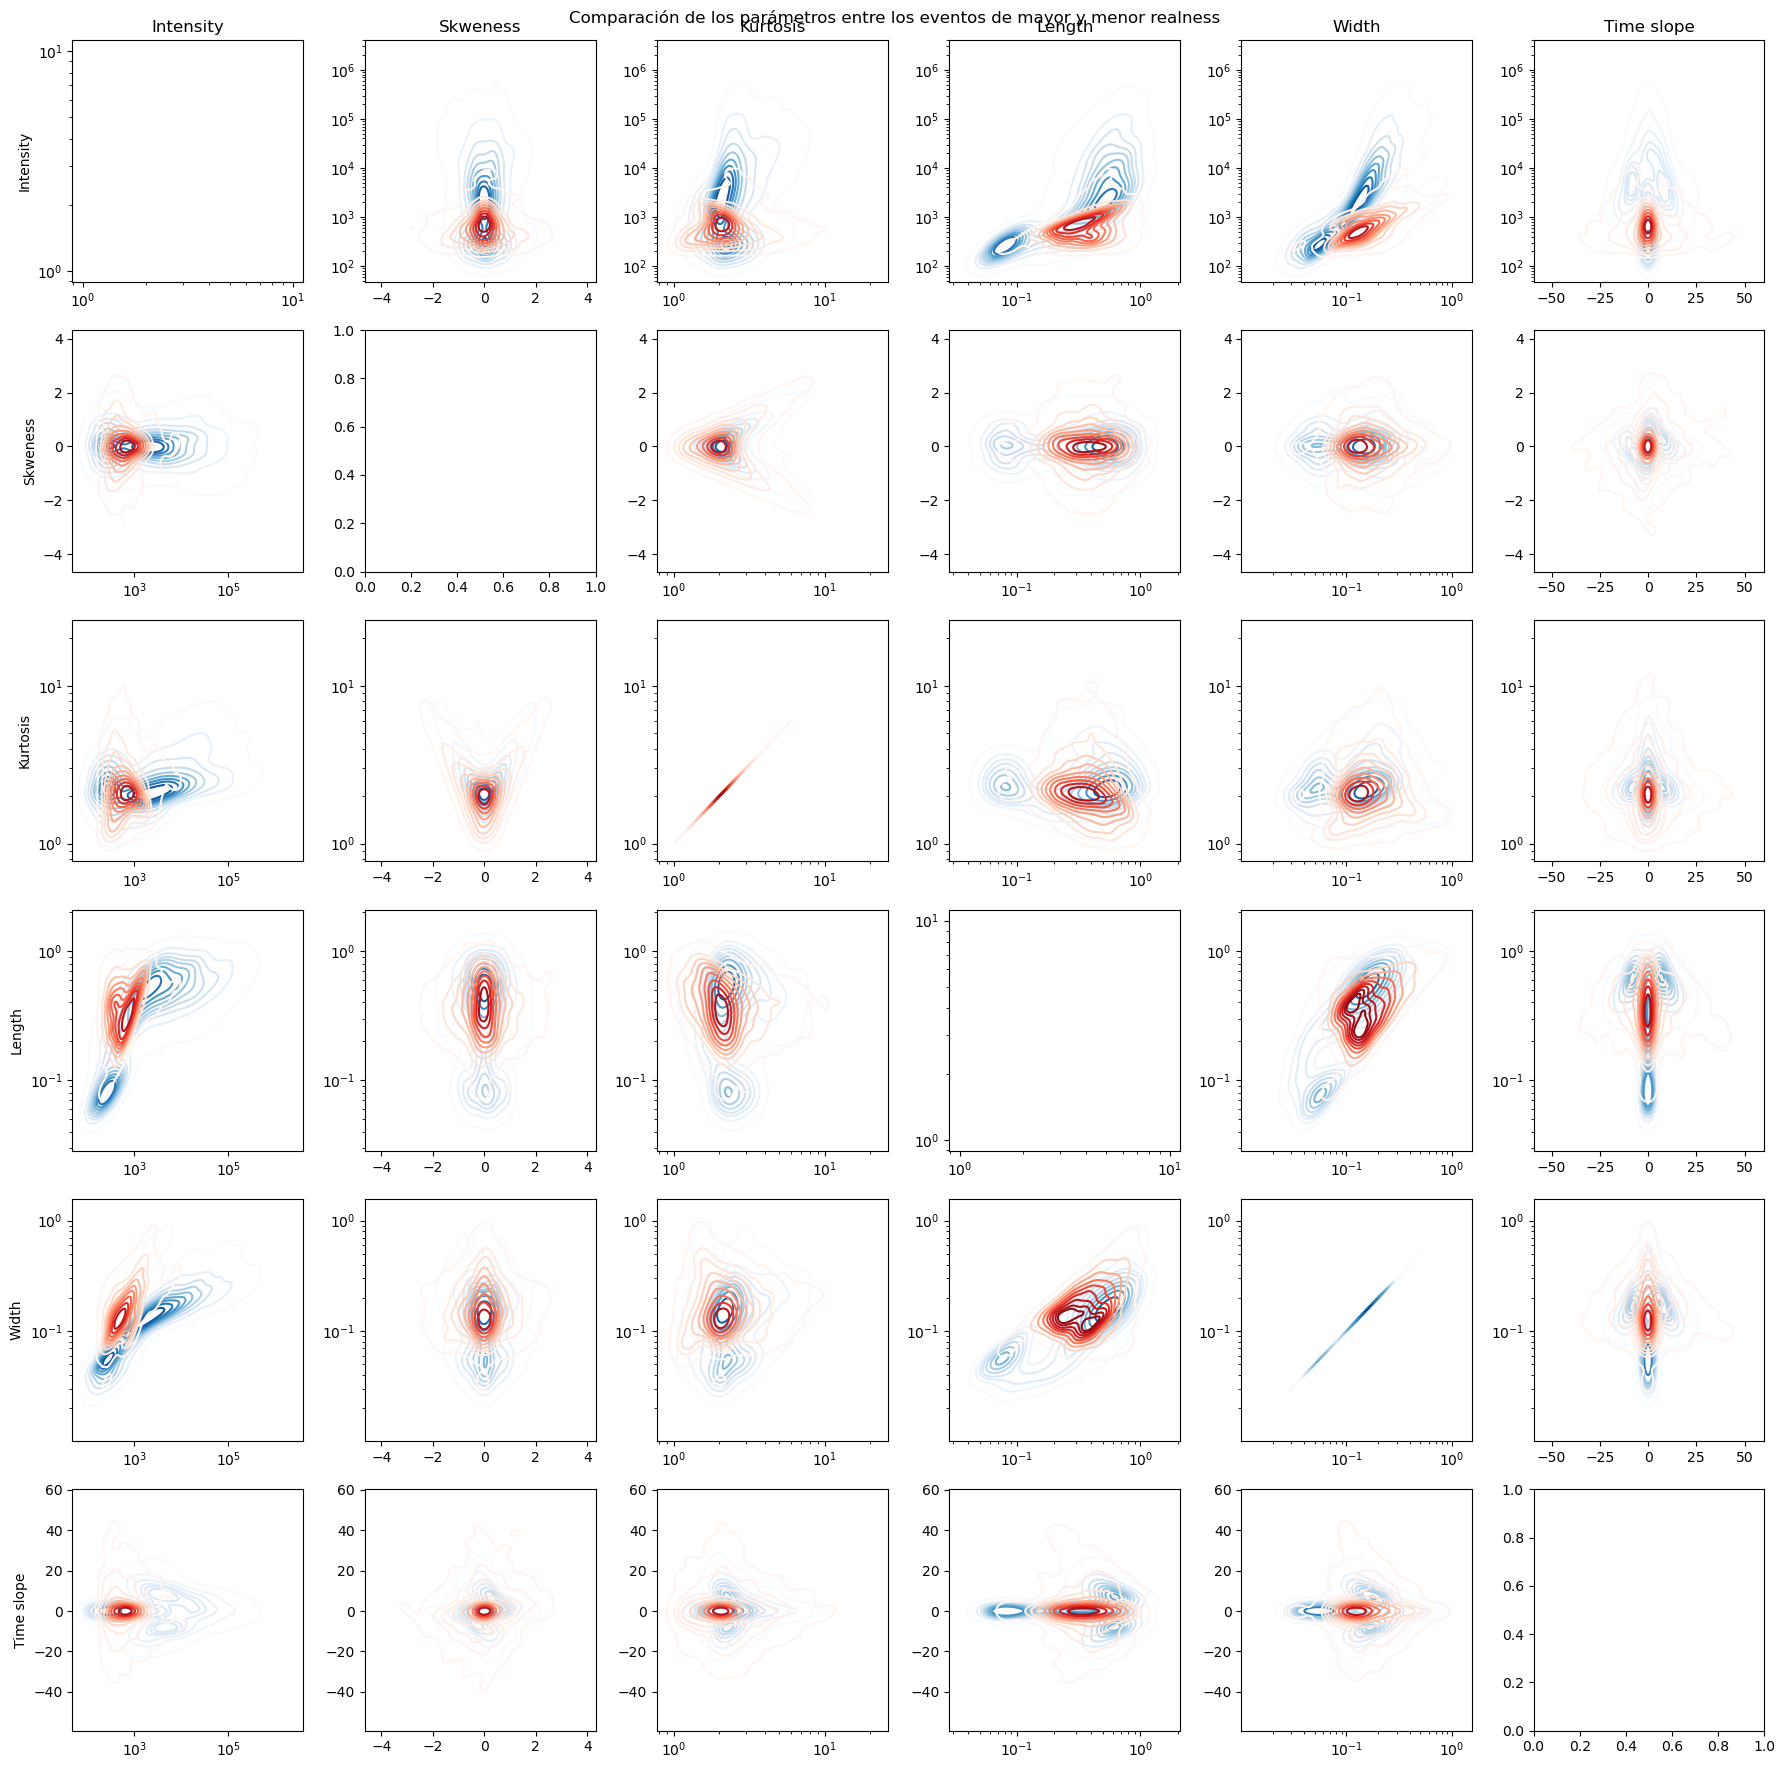

In [39]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        if np.all(X_simulados_mas[:-14418, j] > 0) and np.all(X_reales_mas[:-76009, j] > 0):
            ax.set_xscale('log')
        if np.all(X_simulados_mas[:-14418, i] > 0) and np.all(X_reales_mas[:-76009, i] > 0):
            ax.set_yscale('log')
        
        # Representar los datos
        sns.kdeplot(x=X_simulados_mas[:-14418, j], y=X_simulados_mas[:-14418, i], cmap='Blues', thresh=0.02, ax=ax)
        sns.kdeplot(x=X_reales_mas[:-76009, j], y=X_reales_mas[:-76009, i], cmap='Reds', thresh=0.02, ax=ax)
        
plt.suptitle('Comparación de los parámetros entre los eventos de mayor y menor realness')
plt.tight_layout()
fig.savefig('Comparación extremos5.png')
plt.show()